# Generative Adversarial Networks (GANs)

In this lab, we will be working with GANs.

In [1]:
%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from scipy.stats import entropy
import copy

import itertools

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()

## 1. Introduction and Motivation

As a recap from lecture:

GANs are a popular architecture class for
generating data first introduced in (Goodfellow et al 2014). 

The two major components of a GAN framework are a Discriminator network $D$ and
a Generator network $G$.

$D$ takes a data sample as input and decides whether it is real (coming from the actual 
training set) or fake (generated artificially). $G$ takes some random noise vector
$z$ as input and outputs a generated sample. 

In practice, these networks "battle": $G$ continually attmepts to generate
more realistic samples and $D$ continually tries to get better at distinguishing
real samples from fake smaples. This can be formulated as a min-max zero sum game:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log 1 - D(G(z))]$$
where $p_z(z)$ denotes a defined prior over the noise vector. Local and global minima for this problem exist at local and global Nash Equilibria.

The hope is that, over training, $D$ becomes a very good discriminator and $G$ becomes
a very good generator. At the end of training, we can then make use of $G$
to generate nice looking samples that seem like they were drawn from the original
distribution.

## 2. GAN for Gaussian Distribution

As an introduction, we will define and train a GAN that can replicate a simple
Gaussian distribution.

Let's start by generating random samples from a Gaussian distribution and plotting.

torch.Size([1500, 1])


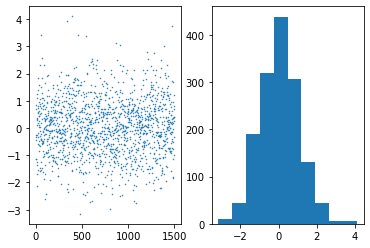

In [2]:
N = 1500
x = torch.randn(N)
x = x.view(-1,1)

#Plotting:
plt.subplot(1, 2, 1)
plt.plot(x.cpu().data.numpy(),'o',markersize=0.5)
plt.subplot(1, 2, 2)
plt.hist(x.cpu().data.numpy());
print(x.shape)

Now, let's define D and G networks as described in the introduction.

First, let's define the generator network $G$. 
We want a network which maps $k$-dimensional noise vectors to samples
from the Gaussian distribution. In other words, we want a mapping
$\mathbb{R}^k \rightarrow \mathbb{R}$. Define a simple, small MLP which performs this mapping.

In [3]:
class generator_mlp(nn.Module):
    # initializers
    def __init__(self, k):
        super(generator_mlp, self).__init__()
        #TO-DO
        self.mlp = nn.Linear(k, 1) 
        
    # forward method
    def forward(self, input):
        #TO-DO
        x = input
        x = self.mlp(x)
        x = x.view(x.size(0), -1)
        return x
        
k=10 #feel free to change k
G = generator_mlp(k)


Next, let's define the discriminator network $D$. 
We want a network which maps a candidate sample, possibly from the Gaussian 
distribution to the probability of that candidate sample belonging to the 
true Gaussian distribution. In other words, we want a mapping
$\mathbb{R} \rightarrow [0,1]$. Define a simple, small MLP which performs this mapping.

In [4]:
class discriminator_mlp(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator_mlp, self).__init__()
        #TO-DO
        self.d_mlp = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )
    # forward method
    def forward(self, input):
        x = input
        x = self.d_mlp(x)
        x = x.squeeze(1)
        return x
    
D = discriminator_mlp()


### 2.1. Training the GAN

Now, we will set up the $D, G$ training regime. We iterate over our training
set (the Gaussian distribution samples). For each batch:

1. For the discriminator, push $D$ towards identifying each sample in the batch as probability close to 1 (i.e. belonging to the true distribution). We then generate an equal number of artificial samples with $G$ and push $D$ towards identifying each sample in the batch as probability close to 0 (i.e. that it is a fake sample). Both of these are done through minimizing BCE loss.
2. For $G$, we will take another random batch of artificial samples and update $G$ in such a way that we push $D$ towards identifying the artificial samples as real. This is done through maximizing BCE loss.

In our case, we train over 50 epochs with a batch size of 32.

#### Deliverables:

While keeping epochs and batch size fixed, modify the optimizer and your
$D$ and $G$ architectures such that the samples from $G$ approximate the curve
"well." **After training, the mean and variance of your G samples should be within 0.15 of the mean and variance of th true distribution.**

For this seciton, $D$ and $G$ **architectures are restricted to MLPs only**
(No restrictions on regularization methods though.)

[10/50] - loss_d: 1.392, loss_g: 0.702
[20/50] - loss_d: 1.389, loss_g: 0.698
[30/50] - loss_d: 1.388, loss_g: 0.696
[40/50] - loss_d: 1.388, loss_g: 0.695
[50/50] - loss_d: 1.388, loss_g: 0.695

Generator statistics:
Mean: 0.073593885 Var: 0.26388073
True distribution statistics:
Mean: 0.043193024 Var: 1.0255612


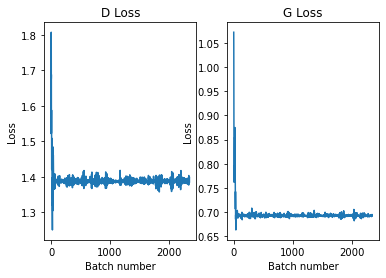

In [5]:
epochs = 50 #keep fixed
batch_size = 32 #keep fixed
lr = 0.2

G = generator_mlp(k)
D = discriminator_mlp()

#data loader:
train = torch.utils.data.TensorDataset(x)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

#D,G optimizers:
G_optimizer = optim.SGD(G.parameters(), lr=lr)
D_optimizer = optim.SGD(D.parameters(), lr=lr)

#loss definition(s):
BCE_loss = nn.BCELoss()

#training loop:
D_losses = []
G_losses = []
for epoch in range(epochs):
    for x_ in train_loader:

        x_ = x_[0]
        
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_), Variable(y_real_), Variable(y_fake_)
        D_result = D(x_)
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, k))
        
        z_ = Variable(z_)
        G_result = G(z_)

        D_result = D(G_result)
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()
        
        D_losses.append(D_train_loss.data.item())
        
        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, k))
        z_ = Variable(z_)

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data.item())
    
    if ((epoch+1)%10==0):
        print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(D_losses)),
                                                                  torch.mean(torch.FloatTensor(G_losses))))

#Plotting:

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

#Samples from G:
z_ = torch.randn((1500, k))
z_ = Variable(z_)

G_result = G(z_)

print()
print('Generator statistics:')
print('Mean:',G_result.cpu().data.numpy().mean(),'Var:',G_result.cpu().data.numpy().std())
print('True distribution statistics:')
print('Mean:',x.cpu().data.numpy().mean(),'Var:',x.cpu().data.numpy().std())


For these loss plots, you'd like to see some periodic oscillation for both nets, followed by convergence.

##### Visualizing the samples:

These cells visualize the $G$ samples and the original dataset. For visualization purposes, you'd like to see the spread and histograms to match somewhat.

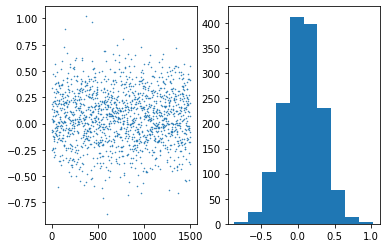

In [6]:
#Samples from G:
z_ = torch.randn((1500, k))
z_ = Variable(z_)

G_result = G(z_)
plt.subplot(1, 2, 1)
plt.plot(G_result.cpu().data.numpy(),'o',markersize=0.5)
plt.subplot(1, 2, 2)
plt.hist(G_result.cpu().data.numpy());

torch.Size([1500, 1])


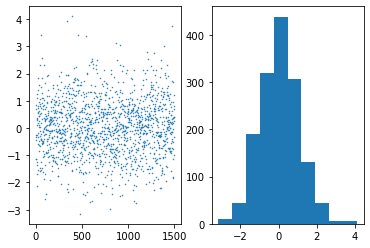

In [7]:
plt.subplot(1, 2, 1)
plt.plot(x.cpu().data.numpy(),'o',markersize=0.5)
plt.subplot(1, 2, 2)
plt.hist(x.cpu().data.numpy());
print(x.shape)

## 3. Experiments on MNIST

Now we move on to MNIST experiments.

### 3.1. Inception Score

Rather than just eye-balling whether GAN samples look good or not,
researchers have come up with objective metrics for determining the quality
and breadth of GAN outputs. One such metric is called the inception score (IS),
which we will be using, although it is not without its drawbacks. It can be implemented in multiple ways. The higher the inception score, the better our GAN model is.

A detailed and thorough explanation of IS can be found from multiple sources. Roughly stated, for a dataset with a given number of classes, high inception scores correspond to GAN samples that have low intra-class entropy and high inter-class entropy.

In [8]:
def MNIST_IS(imgs, model_path='MNIST.ckpt', batch_size=32, splits=10):
    
    """Computes the inception score of the generated images imgs
    imgs -- numpy array of dimension (# of datapoints, 1, 28, 28)
    batch_size -- batch size for feeding into the pretrained MNIST model
    splits -- number of splits
    """
    N = len(imgs)
    
    #check imgs is numpy array & of desired dimension
    assert type(imgs) is np.ndarray
    assert imgs.shape[1] == 1
    assert imgs.shape[2] == 28
    assert imgs.shape[3] == 28
    assert batch_size > 0
    assert N > batch_size
    
    imgs = copy.copy(imgs)
    
    # Set up dtype
    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor
    
    MEAN = 0.1307
    STD = 0.3081
    imgs -= MEAN
    imgs /= STD
    
    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    MNIST_model = ConvNet()
    MNIST_model.load_state_dict(torch.load(model_path))
    if torch.cuda.is_available():
        MNIST_model = MNIST_model.cuda()
    MNIST_model.eval()

    def get_pred(x):
        if torch.cuda.is_available():
            x = x.cuda()
        x = MNIST_model(x)
        return F.softmax(x, dim=0).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 10))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

#Model structure of the pretrained MNIST data
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


Now, let's see the inception score for the actual MNIST dataset.

You will need to make sure the provided `MNIST.ckpt` file is in your working directory or specify its path via the `model_path` argument of `MNIST_IS`. If using Google Colab, click `View` --> `Table of Contents` --> `Files` and then upload the `MNIST.ckpt` file.

The cell below gives an IS estimate for some MNIST samples.

In [9]:
transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=500, shuffle=True)

for x, y in train_loader:
    x = x
    break
x = x.cpu().data.numpy()
x = x.reshape([-1,1,28,28])
print('Shape of data:',x.shape)
mis = MNIST_IS(x)
print('Inception Score:','mean:',mis[0],'std:',mis[1])

Shape of data: (500, 1, 28, 28)
Inception Score: mean: 9.06305993725223 std: 0.6049875141827811


The score for MNIST should be somewhere around 8 to 12. As we train our GAN(s), we will be looking to
get as high an inception score as possible on our generated images.


### 3.2. Generating MNIST images

As you did with the Gaussian distribution, see if you can train D and G
such that G can generate nice images for MNIST. **You are free to use any architecture class, but keep it fairly computationally inexpensive, if possible.** Simple CNNs are good guidelines for computational tractability.

#### Deliverables

Given the limited computational resources, you will want to achieve an inception score of 1.5 or greater for full credit. An IS of 1.5 won't yield great images. For nice looking images, you'll need an inception score of around 6.0, but it is not needed for full credit.

Scores higher than 1.5 will receive bonus points.

#### Instructions for long training times

For more complicated architectures, if your model takes a long time to train, you will need to save the model and write a code snippet that loads it such that the code runs with no errors and we can grade it expediently. In this case, set epochs = 0 and include the saved model in your submission on blackboard (or a Google drive link / something similar if it is too large for BB).

#### Some Optional Tips

It will be easier to get better results with a convolutional GAN as MLPs are typically not used in practical settings. Deconvolutional layers (implemented via `nn.ConvTranspose2d` in pytorch) are typically used. I suggest paying attention to the shapes at each line of the forward pass to avoid errors.

There are additional GAN architectures online you may want to reference for inspiration. (But do not plagiarize -- please write your own custom network.)

In [37]:
#Defining your networks:

class generator(nn.Module):
    # initializers
    def __init__(self,k, d=2):
        super(generator, self).__init__()
  
        self.Generator=nn.Sequential(
        nn.Linear(k,150),
        nn.ReLU(True),
        nn.Linear(150,300),
        nn.ReLU(True),
        nn.Linear(300, 784),
        nn.Tanh()#change it into range of (-1,1)
    )

        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):

        img = self.Generator(input)
        img = img.view(img.size(0), -1)
        return img
        
k=10 #feel free to change k

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=2):
        super(discriminator, self).__init__()
        self.Discriminitor=nn.Sequential(
        nn.Linear(784, 300),
        nn.LeakyReLU(0.2),
        nn.Linear(300,150),
        nn.LeakyReLU(0.2),
        nn.Linear(150,1),
        nn.Sigmoid()
    )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, img):
        x = img.view(img.size(0), -1)
        x = self.Discriminitor(x)
        x = x.squeeze(1)
        return x


The training code is below. Feel free to modify  it.

Training start!
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Siz

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Siz

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Siz

torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([3

torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([3

???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Siz

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([3

torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([3

torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([32, 784])
orz
torch.Size([32, 784])
???
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
???
torch.Size([32, 10])
torch.Size([3

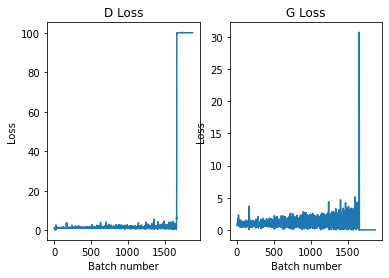

In [38]:
#Training code:

gpu_boole = torch.cuda.is_available()
cnn_boole = False #set True for CNN reshaping. False otherwise.
epochs = 1
batch_size = 32 
lr = 0.2

# choose your own d
G = generator(k, d=4)
D = discriminator(d=4)

if gpu_boole:
    G = G.cuda()
    D = D.cuda()
    
#data loader:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

#D,G optimizers:
G_optimizer = optim.SGD(G.parameters(), lr=lr)
D_optimizer = optim.SGD(D.parameters(), lr=lr)

#loss definition(s):
BCE_loss = nn.BCELoss()

#training loop:
D_losses = []
G_losses = []
print("Training start!")
for epoch in range(epochs):
    for x_, _ in train_loader:
        
        #reshaping depending on your architecture class:
        if not cnn_boole:
            x_ = x_.view(batch_size,-1) #this reshape is needed for MLP class
        if gpu_boole:
            x_ = x_.cuda()
        
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        if gpu_boole:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()

        x_, y_real_, y_fake_ = Variable(x_), Variable(y_real_), Variable(y_fake_)
        D_result = D(x_)
        #print(x_.size())
        #print(y_real_.size())
        #print(D_result.size())
        
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, k))
        if cnn_boole:
            z_ = z_.view(-1, k, 1, 1) #needed for CNN        
        z_ = Variable(z_)
        if gpu_boole:
            z_ = z_.cuda()
            
        print(z_.size())
        
        G_result = G(z_)
        
        print('orz')
        print(G_result.size())
        D_result = D(G_result)
        
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()
        
        D_losses.append(D_train_loss.data.item())
        
        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, k))
        if cnn_boole:
            z_ = z_.view(-1, k, 1, 1) #needed for CNN
        z_ = Variable(z_)
        if gpu_boole:
            z_ = z_.cuda()
            
    
        G_result = G(z_)
       
        
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data.item())
    
    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(D_losses)),
                                                                  torch.mean(torch.FloatTensor(G_losses))))

#Plotting:

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

##### Computing inception score:

In [39]:
# Samples from G:
z_ = torch.randn((1500, k))
z_ = Variable(z_)
if gpu_boole:
    z_ = z_.cuda()
if cnn_boole:
    z_ = z_.view(-1, k, 1, 1) #needed for CNN        
    
G_result = G(z_)
G_result = G_result.cpu().data.numpy()
G_result = G_result.reshape([1500,1,28,28])

mis = MNIST_IS(G_result)
print('Inception Score:','mean:',mis[0],'std:',mis[1])

???
torch.Size([1500, 10])
torch.Size([1500, 784])
Inception Score: mean: 1.0898446098139187 std: 0.007343229384917096


##### Visualizing GAN samples

???
torch.Size([1500, 10])
torch.Size([1500, 784])


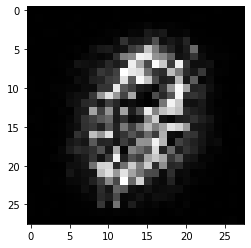

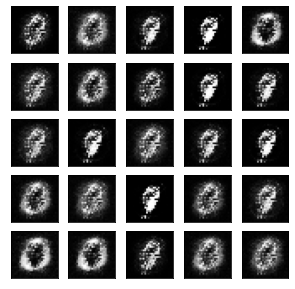

In [40]:
# Samples from G:
z_ = torch.randn((1500, k))
z_ = Variable(z_)
if gpu_boole:
    z_ = z_.cuda()
if cnn_boole:
    z_ = z_.view(-1, k, 1, 1) #needed for CNN        

G_result = G(z_)
G_result = G_result.cpu().data.numpy()
G_result = G_result.reshape([1500,28,28])

plt.imshow(G_result[0],cmap='gray')

size_figure_grid = 5
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

for kr in range(5*5):
    i = kr // 5
    j = kr % 5
    ax[i, j].cla()
    ax[i, j].imshow(G_result[kr], cmap='gray')
